**Question: is it possible to predict the number of followers [followers_count] that a person will have on Twitter, based on their other attributes? **

A user's attributes include:
- When the account was created [created_at]: probably super important. The longer someone has been a user for, likely the more followers they have
- Whether or not they have a profile image [default_profile_image]. I'd expect users with a profile image to have more followers
- Description: Could length of description make a difference?
- favourites_count: More active users could favourite more, and also have more followers?
- following: Could potentially be a positive correlation between followers and following, although not necessarily; some very popular accounts are following very few people
- lang: I'd expect users using english/spanish to have more followers
- statuses_count: people with more statuses are more active users, and probably have more followers
- verified: More likely to be a real human
- withheld_in_countries: users with witheld profile possibly have fewer followers?

How many data points do I need for my model? Some sources state at least 20 observations per vairable as a general rule of thunb. How many user profiles can I pull from Twitter in a reasonable amount of time?


Should I get my users from a particular source, or can I just pull them randomly from Twitter?

In [372]:
import twitterscrape
import tweepy
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import powerlaw
import math
import numpy as np
from __future__ import division
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [165]:
api = twitterscrape.authenticate()

In [166]:
#This gets all of the ids for the followers of the RC
ids = []
for page in tweepy.Cursor(api.followers_ids, screen_name="recursecenter").pages():
    ids.extend(page)
    time.sleep(60)

In [167]:
len(ids)


17548

Twitter places [limits](https://dev.twitter.com/rest/public/rate-limits) on how many times you can ping them per 15 minutes. [GET Users/Lookup](https://dev.twitter.com/rest/reference/get/users/lookup) returns up to 100 users per request. I am allowed to send 180 Lookup requests per 15 minutes = 18000 users per 15 minutes. So I should be able to do them all no problem in one 15 minute block, no token bucket required.

In [168]:
ids[0]

100408795

In [169]:
def get_users(ids):
    last_index = 0
    results = []
    for i in range(100,len(ids),100):
        result = api.lookup_users(ids[last_index:i])
        
        last_index = i
        results.append(result)
    return results

In [170]:
RC_followers = get_users(ids)

In [171]:
len(RC_followers)

175

In [180]:
RC_followers_concat =  [inner 
                        for outer in RC_followers 
                        for inner in outer]

In [209]:
#this is a way of getting attributes from 
getattr(RC_followers_concat[0],'name')

u'Dave Bryand'

In [211]:
columns_list = ["name", "created_at","default_profile_image", "description", "favourites_count", "followers_count", "friends_count", "lang", "listed_count", "protected", "statuses_count", "time_zone", "verified", "withheld_in_countries"]

In [214]:
#create a dictionary using columns where every key contains a list
user_dict = {column:[getattr(user,column) if hasattr(user,column) else None for user in RC_followers_concat] for column in columns_list}
RC_followers_df = pd.DataFrame(user_dict)

In [223]:
RC_followers_df.head()

,created_at,default_profile_image,description,favourites_count,followers_count,friends_count,lang,listed_count,name,protected,statuses_count,time_zone,verified,withheld_in_countries
0,2009-12-30 04:56:18,False,WorkLife Co-founder. On fire about building th...,261,291,704,en,14,Dave Bryand,False,532,Pacific Time (US & Canada),False,None
1,2011-01-23 23:30:47,False,unpopular dolt,9,24,131,en,1,Nimrod Dancer,False,758,Eastern Time (US & Canada),False,None
2,2015-06-30 15:05:36,False,an ardent machine learner. #machinelearning #n...,51,116,223,en,10,Mallikarjun Yelameli,False,60,None,False,None
3,2011-12-13 00:22:03,False,farm-to-table data science,213,25,407,en,2,jawn,False,89,Pacific Time (US & Canada),False,None
4,2011-12-11 05:01:42,False,,120,51,202,en,3,Stewart Stewart,False,35,Arizona,False,None


I first plotted a histogram to see the distribution of the number of followers for each user

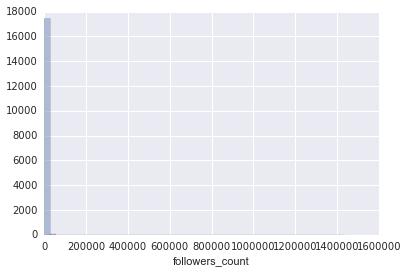

In [323]:
sns.distplot(RC_followers_df.followers_count, kde = False)

I suspect that this is showing a heavy-tailed distribution; there are lots and lots of people with few followers, and a small number of people with may followers; hence, the strange looking plot

In [232]:
RC_followers_df[RC_followers_df.followers_count == RC_followers_df.followers_count.max()]

,created_at,default_profile_image,description,favourites_count,followers_count,friends_count,lang,listed_count,name,protected,statuses_count,time_zone,verified,withheld_in_countries
12994,2008-07-31 06:04:28,False,Trying to Find People Online? Try #PeopleSearc...,6536,1437440,55896,en,473,PeopleSearches.com,False,45529,Pacific Time (US & Canada),False,None


The user with the most followers has 1.4 million followers! A website that specialises in finding people online

In [246]:
RC_followers_df[RC_followers_df.followers_count>10000]

,created_at,default_profile_image,description,favourites_count,followers_count,friends_count,lang,listed_count,name,protected,statuses_count,time_zone,verified,withheld_in_countries
68,2011-07-05 20:27:54,False,Converting caffeine into code and cake into ca...,558,11405,262,en,15,James Shakespeare,False,2092,London,False,None
71,2008-01-22 05:42:15,False,"i write php + js at @bocoup, build https://t.c...",57822,14176,1666,en,744,jennmoneydollars,False,56639,Eastern Time (US & Canada),False,None
128,2014-07-18 16:58:39,False,Citizenship through Social Innovation,266,36330,32757,en,124,The Worldplayers,False,1657,Pacific Time (US & Canada),False,None
183,2008-12-10 13:34:22,False,Code // Crypto // Security.\n\nWorking on pri...,7862,11138,848,en,548,Frederic Jacobs,False,5813,Brussels,False,None
202,2008-01-29 14:58:18,False,A payments company that provides elegant tools...,3639,21310,22699,en,569,Braintree,False,4944,Pacific Time (US & Canada),True,None
275,2009-10-14 13:55:58,False,The official account of MIT's largest research...,988,14033,3906,en,636,CSAIL at MIT,False,1882,Eastern Time (US & Canada),False,None
280,2011-08-11 22:54:41,False,My contents reveal all. Email nytfridge at gma...,158197,12502,10665,en,350,NYTFridge,False,40196,Atlantic Time (Canada),False,None
405,2009-04-27 17:14:44,False,Strategist focused on securing IT operations a...,2364,32648,29487,en,845,J Wolfgang Goerlich,False,10551,Eastern Time (US & Canada),False,None
466,2011-02-12 06:06:05,False,"I’m an engineer, graduate of Brown University,...",81,38499,258,en,5,Susan Goldblatt,False,206,Eastern Time (US & Canada),False,None
626,2009-02-18 01:51:08,False,ALL MED SEARCH. I place healthcare professiona...,223,25643,7311,en,96,Nadia Gruzd,False,1606,Pacific Time (US & Canada),False,None


In [234]:
RC_followers_df_cleaned = RC_followers_df.drop(12994)

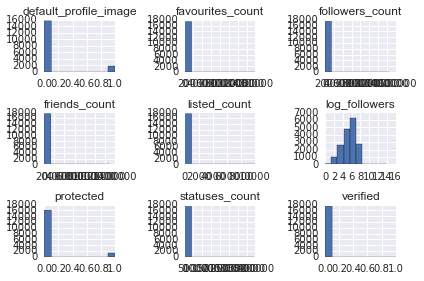

In [334]:
RC_followers_df.hist()
plt.tight_layout()

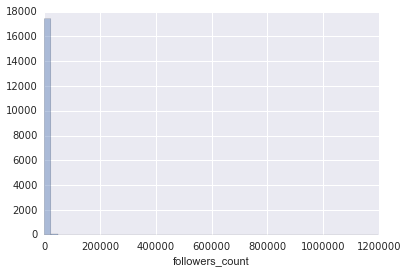

In [260]:
sns.distplot(RC_followers_df_cleaned.followers_count, kde = False)

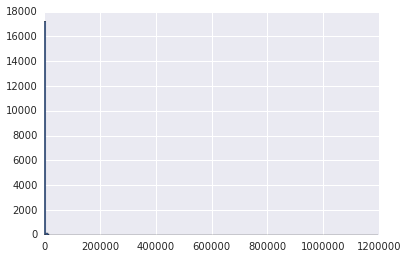

In [247]:
RC_followers_df_cleaned.followers_count.hist(bins = 200)

In [250]:
RC_followers_over_100 = RC_followers_df[RC_followers_df.followers_count>100]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

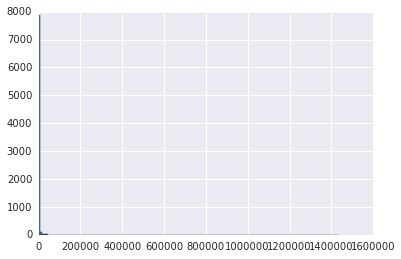

In [251]:
RC_followers_100.followers_count.hist(bins = 200)

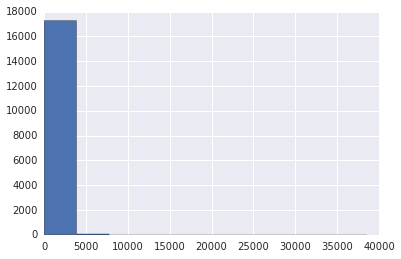

In [332]:
RC_followers_df[RC_followers_df.followers_count<10000].friends_count.hist()

In [258]:
RC_followers_under_10000.followers_count.max()

9985

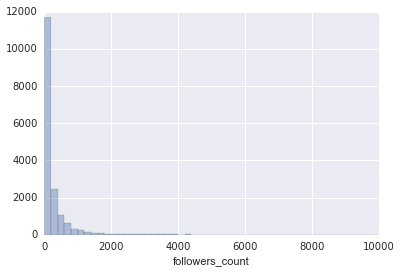

In [261]:
sns.distplot(RC_followers_under_10000.followers_count, kde = False)

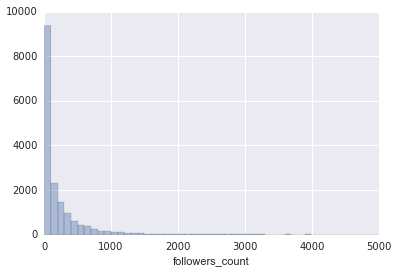

In [263]:
sns.distplot(RC_followers_df.followers_count[RC_followers_df.followers_count<5000], kde = False)

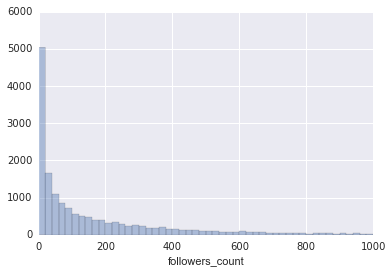

In [264]:
sns.distplot(RC_followers_df.followers_count[RC_followers_df.followers_count<1000], kde = False)

In [265]:
sum(RC_followers_df.followers_count)

17450052

In [ ]:
sum(RC_followers_df.followers_count)

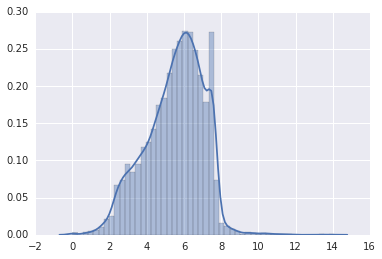

In [337]:
sns.distplot([math.log(count) for count in RC_followers_df.friends_count if count>0], bins =50)

In [283]:
len(RC_followers_df[RC_followers_df.followers_count==0])/len(RC_followers_df)
#only 4% users have no followers

0.04222857142857143

Use the powerlaw package to model the distribution

In [349]:
RC_followers_df_nozero = RC_followers_df[RC_followers_df.followers_count!=0]

In [351]:
fit = powerlaw.Fit(RC_followers_df_nozero.followers_count)

Calculating best minimal value for power law fit


In [312]:
#alpha is the The parameter of the power law. The slope on a log-log plot.
fit.power_law.alpha

1.8786777775094308

In [321]:
#xmin shows the minimum value at which the power law starts
fit.power_law.xmin

1196.0

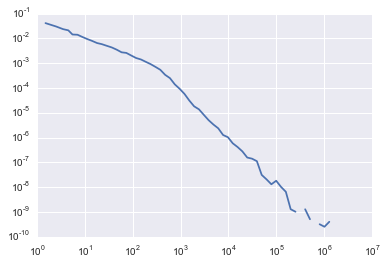

In [292]:
#probability density function for the data. Note the kink at around 10^2, around the point of xmin
powerlaw.plot_pdf(RC_followers_df_nozero.followers_count)

In [295]:
R, p = fit.distribution_compare("power_law","exponential", normalized_ratio=True)

In [296]:
print R, p

6.58898688778 4.42837889919e-11


In [301]:
R, p = fit.distribution_compare("exponential","lognormal")
print R, p

-1153.57161293 3.87510028386e-11


In [299]:
R, p = fit.distribution_compare("power_law", "lognormal")
print R, p

-0.274291308296 0.667339520204


There isn't a significant difference between the likelihood of power law and lognormal distributions. Lognormal is a simpler distribution and so I assume this is more likely

In [384]:
RC_followers_df_nozero['Length_of_membership'] = pd.to_datetime('2015-12-03 18:12:46') - RC_followers_df_nozero['created_at']


/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [402]:
current_date = pd.to_datetime('2015-12-03 18:12:46')

In [399]:
def return_days(date):
    return date.days

In [403]:
RC_followers_df_nozero['Length_of_membership'] = RC_followers_df_nozero['created_at'].apply(lambda x:(current_date-x).days)

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [404]:
RC_followers_df_nozero['Length_of_membership']

0        2164
1        1774
2         156
3        1451
4        1453
5        2934
6        1618
7         970
8         216
9        2225
10       2466
11          2
12       1991
13       2427
14        273
15       1911
16       3292
17        827
18       1675
19       2486
20       1322
21       2345
22       2737
23        805
24       2423
25        851
26       2305
27        107
28       2431
29        241
         ... 
17470    1979
17471    2765
17472    1626
17473    1841
17474    2828
17475    2314
17476    2686
17477    3279
17478    2615
17479    2246
17480    3185
17481    2239
17482    1892
17483    2585
17484    2386
17485    2514
17486    2759
17487    1666
17488    2228
17489    2492
17490    2751
17491    2473
17492    3058
17493    2739
17494    2843
17495    2584
17496    2497
17497    2469
17498    2310
17499    2415
Name: Length_of_membership, dtype: int64

In [374]:
#split dataset up into train and test sets
mask = np.random.rand(len(RC_followers_df_nozero))<0.8
RC_train = RC_followers_df_nozero[mask]
RC_test = RC_followers_df_nozero[~mask]

In [344]:
RC_followers_df.to_csv("RC_followers_df.csv", encoding = 'utf-8')

In [377]:
RC_train.to_csv("RC_train.csv", encoding = 'utf-8')
RC_test.to_csv("RC_test.csv", encoding = 'utf-8')

In [381]:
len(RC_train)
RC_train.tail()

,created_at,default_profile_image,description,favourites_count,followers_count,friends_count,lang,listed_count,name,protected,statuses_count,time_zone,verified,withheld_in_countries,log_followers
17491,2009-02-24 18:12:46,True,,2,81,900,en,3,ks,True,267,Amsterdam,False,None,6.802395
17492,2007-07-20 09:21:58,False,Blake Johnson,107,651,506,en,33,blake johnson,False,2890,Eastern Time (US & Canada),False,None,6.226537
17496,2009-01-31 09:12:35,False,"Product Design at Ringly. Previously eBay, Hun...",103,272,374,en,16,Bill Gaines,False,1080,Eastern Time (US & Canada),False,None,5.924256
17498,2009-08-06 01:46:56,True,,7,125,63,en,8,_,True,1161,Eastern Time (US & Canada),False,None,4.143135
17499,2009-04-23 03:32:51,False,Programmer/QA/budding drummer,1356,101,227,en,19,Isaul Vargas,False,2821,Eastern Time (US & Canada),False,None,5.424950
